Dependencies

In [2]:
import scipy.stats as st
import numpy as np
import math as ma
import random as r

def generate_alpha_hat(X, R, beta):
    summation = 0
    for i in range(0, len(R)):
        summation += ((R[i] + 1 ) * ma.log(1 + (X[i]/beta)) )
    alpha = m / summation
    return alpha

def generate_x(beta, n):
    return list(st.lomax.rvs(beta, size=n).tolist())

def progressive_type_two(beta, R, X, m, alpha):
    n = len(X)
    U = [np.random.uniform(0, 1) for i in range(0, m)]
    Z = [-ma.log(1 - U[i]) for i in range(0, m)]
    type2_exp = generate_type2_x(Z, R, m , n)
    prog_type_two = [inverse_function_cdf(beta, alpha, (1 - ma.exp(-x))) for x in type2_exp]
    prog_type_two.sort()
    return prog_type_two

def generate_type2_x(Z, R, m, n):
    type2_x = []
    type2_x.append(Z[0]/n)
    for i in range(2, m+1):
        type2_x.append(type2_x[i-2] + (Z[i-1]/(n - sum(R[:i-2]) - i + 1)))
    type2_x.sort()
    return type2_x[:]


def inverse_function_cdf(beta, alpha, x):
    try:
        return ma.exp(ma.log(beta) - ((ma.log(1 - x)/ alpha))) - beta
    except OverflowError:
        return float('inf')

# def inverse_function_cdf(beta, alpha, x):
#     try:
#         return -ma.log(1 - x) / (alpha)
#     except OverflowError:
#         return float('inf')

def generate_s1_asterisk(x, beta, alpha):
    s1_asterisk = ((beta / (x + beta)) ** alpha)
    return s1_asterisk

def random_R_generator(m, n):
    R = [0] * (m)
    required_sum = n - m
    sum_counter = required_sum
    positions = [i for i in range(0,m)]
    position = 0

    while (sum(R) != required_sum):
        if len(positions) == 0:
            break
        position = r.sample(positions, 1)[0]
        positions.remove(position)
        R[position] = r.randint(1, sum_counter)
        sum_counter = sum_counter - R[position]
    return R
 
def generate_obs_alpha( X, R, beta):
    first = 0 
    second = 0
    for i,j in zip(X, R):
        first += (1 + j) * (ma.log(i + beta))
        second +=  (j * ma.log(beta)) 
    second += m * ma.log(beta)
    return m / (first - second)
    
def generate_S0_asterisk(m , s_asterisk, significance_level):
    try:
        return ma.exp((2 * m * ma.log(s_asterisk)) / st.chi2.ppf(q = 1 - significance_level, df = 2 * m + 2))
    except OverflowError:
        return float('inf')
    
def generate_S_hat(x , beta, alpha):
    return ((beta / (x + beta)) ** (alpha))

<h1> Algorithm 1 </h1>
<br>
Real life Data

<b> Parameter Estimation </b>

In [3]:
import math as ma
from tqdm import tqdm

X = [0.19, 0.78, 0.96, 1.31, 2.78, 4.85, 6.5, 7.35]
R = [0, 0, 0, 0, 0, 0, 0, 11]

m = len(X)
n = 19
beta = 4.5382
significance_level = 0.05

In [4]:
def generate_alpha_WT(X, R, beta):
    summation = 0
    for i in range(0,len(R)):
        summation += ((R[i] + 1 ) * ma.log(1 + (X[i]/beta)) )
    alpha = m / summation
    return alpha
print("The value of alpha is ::: ", generate_alpha_WT(X, R, beta))

The value of alpha is :::  0.559640496975666


<b> 


<b> Monte Carlo Simulation </b>

In [5]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

class algo_one:
    x: float
    m: int
    n: int
    alpha: float
    beta: float
    significance_level : float
    R : list
    s_asterisk : float
    
    def __init__(self, x, m , n, s_asterisk, beta, significance_level, alpha ): 
        self.x = x
        self.m = m
        self.n = n
        self.s_asterisk = s_asterisk
        self.beta = beta
        self.significance_level = significance_level
        self.alpha = alpha
        
    def step_one(self, S0_asterisk):
        count = 0
        X = generate_x(self.alpha, self.n)
        transformed = progressive_type_two(self.beta, self.R, X, self.m, self.alpha)    
        alpha_hat = generate_alpha_WT(transformed, self.R, self.beta)
        S_hat = generate_S_hat(self.x, self.beta, alpha_hat)
        
        if S_hat > (S0_asterisk):
            return 1
        else:
            return 0
        return count

    def step_two(self, S0_asterisk):
        total_count = 0
        for i in range(1,101):
            total_count += self.step_one(S0_asterisk)
        power = total_count / 100
        return power

    def generate_SMSE(self, power_list, mean):
        SMSE = 0
        for i in power_list:
            SMSE += (i - mean) ** 2
        return SMSE

    def step_three(self):
        pbar = tqdm(total= 100)
        self.R = [0 for i in range(0, self.m)]
#         self.R = random_R_generator(self.m, self.n)
        power_list = []
        s1_asterisk = self.s_asterisk + .02
#         self.alpha = ma.log(s1_asterisk) / ma.log(self.beta / (self.x + self.beta))
        S0_asterisk = generate_S0_asterisk(self.m, self.s_asterisk + 0.02, self.significance_level)
        for i in range(1,101):
            pbar.update(1)
            power_list.append(self.step_two(S0_asterisk))
        mean = np.mean(power_list)
        SMSE = self.generate_SMSE(power_list, mean)
        pbar.close()
        return mean, SMSE, power_list[:]

In [192]:
algorithm_one = algo_one(x = 2, m = 10, n = 10 , s_asterisk = 0.8, beta = 4, significance_level = 0.2, alpha  = 2)
mean, SMSE, power_list = algorithm_one.step_three()

A Jupyter Widget

In [193]:
print(mean)
print(generate_S_hat(2, 4, 2))

0.0
0.4444444444444444


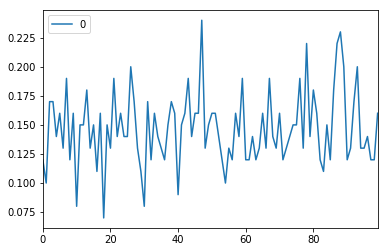

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
data = pd.DataFrame(power_list)
data.plot()
plt.show()

In [8]:
import pandas as pd
ns = [10,10,19,19,19]
ms = [2,5,8,15,19]
alphas = [2.4,3.9,1.98,2.9,2] 
betas = [1,2,3,2,1]
xs = [1, 0.9, 0.8, 0.26, 0.16]
significance = 0.1
cpowers = []
gpowers = []
s_asterisk = []
for x,n,m,alpha,beta in zip(xs, ns, ms, alphas, betas):
    s_asterisk.append(generate_s1_asterisk(x, beta, alpha))
    algorithm_one = algo_one(x, m, n, alpha, beta, significance)
    cpowers.append(algorithm_one.step_three()[0])

power_data = pd.DataFrame()
power_data['n'] = ns
power_data['m'] = ms
power_data['alpha'] = alphas
power_data['beta'] = betas
power_data['s_asterisk'] = s_asterisk
power_data['classical'] = cpowers


TypeError: __init__() missing 1 required positional argument: 'alpha'

In [9]:
power_data

NameError: name 'power_data' is not defined

<IPython.core.display.Javascript object>


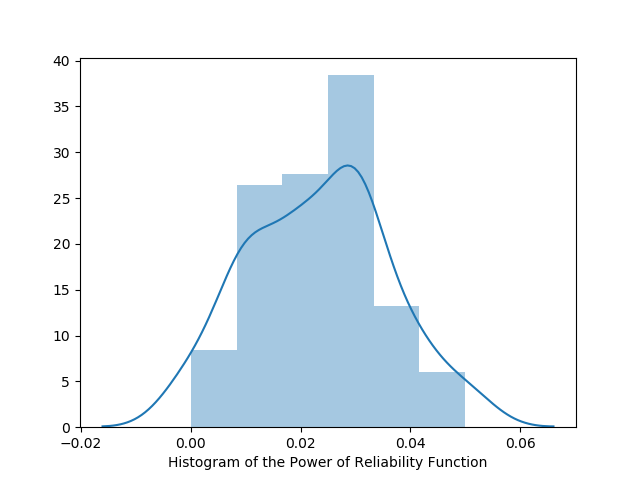

C:\Users\Bikal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [8]:
%matplotlib notebook
sns.distplot(power_list)
plt.xlabel('Histogram of the Power of Reliability Function')
plt.show()

<h1> Algorithm 2 </h1>

In [10]:
import scipy.stats as st
import numpy as np
import math as ma
import random as r
from tqdm import tqdm_notebook as tqdm

significance_level = 0.1

class algo_two:
    x: float
    m: int
    n: int
    alpha: float
    beta: float
    significance_level : float
        
    def __init__(self, x, m , n, alpha, beta, significance_level): 
        self.x = x
        self.m = m
        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.significance_level = significance_level


    def generate_obs_alpha(self, X, R):
        first = 0 
        second = 0
        for i,j in zip(X, R):
            first += (1 + j) * (ma.log(i + self.beta))
            second +=  (j * ma.log(self.beta)) 
        second += self.m * ma.log(self.beta)
        return self.m / (first - second)


    def step_one(self):
        X = generate_x(self.alpha, self.n)
        transformed = progressive_type_two(self.beta, R,  X, self.m, self.alpha)   
        return transformed


    def step_two(self, S0_asterisk):
        count = 0
        Q_s_list = []    
        transformed_X= self.step_one()
        R = random_R_generator(self.m, self.n)
        alpha_hat = self.generate_obs_alpha( transformed_X, R)
        u = np.random.chisquare(2 * self.m + 2)
        Q_alpha = (u * alpha_hat) / (2 * self.m)
        Q_s = ma.exp(Q_alpha * (ma.log(self.beta / (self.beta + self.x))))  
        if Q_s >= (S0_asterisk ):
            Q_s_list.append(Q_s)
            count += 1
        return Q_s_list, count

    def step_three(self):
        Q_s_list = []
        s1_asterisk = generate_s1_asterisk(self.x, self.beta, self.alpha)
        S0_asterisk = generate_S0_asterisk(self.m, s_asterisk, self.significance_level)
        
        pbar = tqdm(total = 10000)
        count = 0
        for i in range(0, 10000):
            Q_s, countt = self.step_two(S0_asterisk)
            count += countt
            Q_s_list.append(Q_s)
            pbar.update(1)
        proportion = count / (10000)
        pbar.close()

        return proportion

In [12]:
algorithm_two = algo_two(x = 2, m = 8, n = 19, alpha = 1, beta = 5, significance_level = 0.2)
algorithm_two.step_three()

TypeError: must be real number, not list

In [23]:
power_data

,n,m,alpha,beta,classical
0,10,2,2.40,1.0,0.0191
1,10,5,3.90,2.2,0.0479
2,19,8,1.98,1.8,0.0497
3,19,15,2.90,2.6,0.0666
4,19,19,3.00,1.0,0.0674


<IPython.core.display.Javascript object>


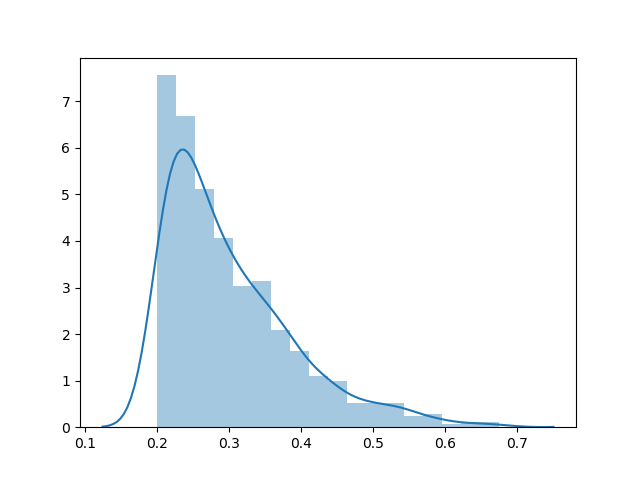

C:\Users\Bikal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [14]:
import pandas as pd
import seaborn as sns

%matplotlib notebook
Q_s = pd.DataFrame(Q_s_list).dropna()
sns.distplot(Q_s)
plt.show()

# Algorithm 3

In [128]:
import scipy.stats as st
import numpy as np
import math as ma
import random as r
from tqdm import tqdm_notebook as tqdm


class algo_three:
    alpha : float
    beta : float
    x : float
    m : int
    n : int
    significance_level : float
    s_asterisk : float
    R : list
    
    def __init__(self, x, m , n, s_asterisk, beta, significance_level, alpha): 
        self.x = x
        self.m = m
        self.n = n
        self.beta = beta
        self.s_asterisk = s_asterisk
        self.significance_level = significance_level
        self.alpha = alpha

    def step_four(self):
        pbar = tqdm(total = 5000)
        count_for_eta = 0
        self.R = [0 for i in range(0, self.m)]
        self.alpha = ma.log(self.s_asterisk + 0.02) / ma.log(self.beta / (self.beta + self.x))
        self.S0_asterisk = generate_S0_asterisk(self.m, self.s_asterisk + 0.02, self.significance_level)
        count_g = []
        count_c = []        
        for i in range(0,5000):
            X = generate_x(self.alpha, self.n)
            transformed = progressive_type_two(self.beta, self.R, X, self.m, self.alpha)
            alpha_hat = generate_alpha_hat(transformed, self.R, self.beta)
            S_hat = generate_S_hat(self.x, self.beta, alpha_hat)
            
            if S_hat > self.S0_asterisk:
                count_c.append(1)
            else:
                count_c.append(0)
                
            count_2 = []
            for j in range(0,200):
                u = np.random.chisquare(2 * self.m + 2)
                alpha_obs = (u * alpha_hat) / (2 * self.m)
                Q_s = ma.exp(alpha_obs * ma.log((self.beta )/ (self.beta + self.x)))
                if Q_s > self.s_asterisk:
                    count_2.append(1)
                else:
                    count_2.append(0)
#                 print(count_2)
            count_g.append(int(np.mean(count_2) < self.significance_level))        
            pbar.update(1)
        
        pbar.close()
        return np.mean(count_c), np.mean(count_g)

In [133]:
algorit_three = algo_three(x = 1, m = 9, n = 9, s_asterisk = 0.43, beta = 4, significance_level = 0.1, alpha = 4)
algorit_three.step_four()

A Jupyter Widget

(0.1126, 0.0866)

Type I Error

1) algorit_three = algo_three(x = 0.5, m = 10, n = 25, s_asterisk = 0.60, beta = 4, significance_level = 0.1, alpha = 4)
Ans : (0.013, 0.0954)
2) algorit_three = algo_three(x = 0.5, m = 10, n = 30, s_asterisk = 0.61, beta = 4, significance_level = 0.1, alpha = 4)
Ans : (0.009, 0.0966)


Power
1) 

In [89]:
generate_S_hat(1, 4, 4)

0.4096000000000001

# Algorithm 4

In [184]:
import pandas as pd
import random as r
def generate_SSE(alpha_list, alpha_hat):
    SSE = 0
    for i in alpha_list:
        SSE += (i - alpha_hat) ** 2
    return SSE

def step_one(transformed_x, R, beta, m):
    a = []
    for i in range(1, m+1):
        temp = m - i + 1
        summation = 0
        for j in range(temp, m + 1):
            summation += R[j - 1] 
        aj = i + summation
        a.append(aj)        
    alpha_list = []    
    
    for i in range(1,m+1):      
        mult = 1
        temp = m - i + 1
        for j in range(temp , m+1):
            mult = mult * (a[j - 1] / (a[j - 1] + 1))        
    
        alpha_list.append(ma.log(1 - (1 - mult)) / ma.log(beta/(transformed_x[i-1]+beta)))
    return alpha_list

def step_two(beta, transformed, R):
    alpha_hat = generate_alpha_hat(transformed, R, beta)
    alpha_list = step_one(transformed, R, beta, 8)    
    SSE = generate_SSE(alpha_list, alpha_hat)
    return alpha_hat, SSE
    
def step_three():
    beta_list = []
    SSE_list = []
    alpha_hat_list = []
    inverse_beta_list = []
#     alpha = r.uniform(1, 9)
#     X = generate_x(beta)    
#     transformed, R = progressive_type_two(beta, X, 8, alpha)
    transformed  = [0.19, 0.78, 0.96, 1.31, 2.78, 4.85, 6.50, 7.35]
    R = [0,0,0,0,0,0,0,11]
    for i in range(60, 90):
        beta = i / 100
        beta_list.append(beta)
        alpha_hat, SSE = step_two(beta, transformed, R)
        alpha_hat_list.append(alpha_hat)
        SSE_list.append(SSE)
    dataframe = pd.DataFrame()
    dataframe['Beta'], dataframe['SSE'], dataframe['alpha_hat']=  beta_list, SSE_list, alpha_hat_list
    return dataframe

In [185]:
df = step_three()
df

,Beta,SSE,alpha_hat
0,0.60,0.008473,0.196872
1,0.61,0.008409,0.198147
2,0.62,0.008349,0.199414
3,0.63,0.008294,0.200674
4,0.64,0.008243,0.201927
5,0.65,0.008197,0.203174
6,0.66,0.008156,0.204414
7,0.67,0.008120,0.205648
8,0.68,0.008088,0.206876
9,0.69,0.008062,0.208097


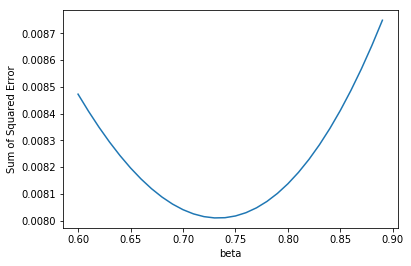

In [186]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(df.Beta, df.SSE)
plt.xlabel('beta')
plt.ylabel('Sum of Squared Error')
plt.show()

Gini Statistics with R

In [198]:
G_m

0.26318353428327845

In [194]:
X = [0.19, 0.78, 0.96, 1.31, 2.78, 3.16, 4.15, 4.67, 4.85, 6.5, 7.35, 8.01, 8.27, 12.06, 31.75, 32.52, 33.91, 36.71, 72.89]
n = len(X)
beta = 0.72
Y = [ma.log(x/beta) for x in X]

D = []
D.append(n * Y[0])

for i in range(2, n+1):
    D.append((n - i + 1) * (Y[i-1] -Y[i-2]))

numerator = 0
for i in range(1, n):
    numerator += (i * D[i])
denominator = sum(D) * (n-1)

G_n = numerator / denominator

In [195]:
G_n

0.41388324809988947

## Algorithm 5

In [288]:
sig_level = 0.1
algorithm_one = algo_one(x = 3, m = 5, n = 10, alpha = 1, beta = 5, significance_level = sig_level)
algorithm_three = algo_three(x = 3, m = 5, n = 10, alpha = 1, beta = 5, significance_level = sig_level)

print("power for algorithm one", algorithm_one.step_three()[0])
print("power value for algorithm three", algorithm_three.step_three())

A Jupyter Widget

s - asterisk 0.625
power for algorithm one 0.00901
s - asterisk 0.625


A Jupyter Widget

power value for algorithm three 0.7339


In [194]:
# import pandas as pd
# ns = [10,10,19,19,19]
# ms = [4,5,8,15,19]
# alphas = [1.5,3.9,1.98,2.9,2] 
# betas = [0.8,2,3,2,1]
# xs = [1, 0.9, 0.8, 0.26, 0.16]
# significance = 0.1
# cpowers = []
# gpowers = []
# s_asterisk = []
# for x,n,m,alpha,beta in zip(xs, ns, ms, alphas, betas):
#     s_asterisk.append(generate_s1_asterisk(x, beta, alpha))
#     algorithm_one = algo_one(x, m, n, alpha, beta, significance)
#     cpowers.append(algorithm_one.step_three()[0])
#     algorithm_three = algo_three(x, m, n, alpha, beta, significance)
#     gpowers.append(algorithm_three.step_four())
    
# power_data = pd.DataFrame()
# power_data['n'] = ns
# power_data['m'] = ms
# power_data['alpha'] = alphas
# power_data['beta'] = betas
# power_data['s_asterisk'] = s_asterisk
# power_data['classical'] = cpowers
# power_data['generalized'] = gpowers

In [224]:
m = 10
n = 20
gamma = 0.05
X = [0.5, 1, 1.5, 2, 2.5, 3]
betas = [0.5,0.5,0.5,1,1,1,1.5,1.5,1.5]
alphas = [1.5,2.5,3.5,1.5,2.5,3.5,1.5,2.5,3.5]
def lower_bound_table(X, betas, alphas, gamma, m , n):
    show_data = pd.DataFrame()
    show_data['beta'] = betas
    show_data['alphas'] = alphas
    
    for x in X:        
        LBc = []
        LBg = []
        for beta, alpha in zip (betas, alphas):
            S_hat = generate_S_hat(x, beta, alpha)
            LBc.append((ma.exp(st.chi2.ppf(q = 1 - gamma , df = 2 * m + 2)) * ma.log(S_hat)) / (2 * m))
            
            u = np.random.chisquare(2 * m + 2)
            Q_alpha = (u * alpha) / (2 * m)
            Q_s = ma.exp(Q_alpha * (ma.log(beta / (beta + x))))
            LBg.append(Q_s)
        string_Classical = """LBc(%f)"""%x
        string_General = """LBg(%f)"""%x
        show_data[string_Classical] = LBc
        show_data[string_General] = LBg
    return show_data
        

In [233]:
lower_bound_table(X, betas, alphas, gamma, m , n)

,beta,alphas,LBc(0.500000),LBg(0.500000),LBc(1.000000),LBg(1.000000),LBc(1.500000),LBg(1.500000),LBc(2.000000),LBg(2.000000),LBc(2.500000),LBg(2.500000),LBc(3.000000),LBg(3.000000)
0,0.5,1.5,-2.812439e+13,0.433969,-4.457611e+13,0.052561,-5.624879e+13,0.162673,-6.530282e+13,0.183142,-7.270050e+13,0.113231,-7.895515e+13,0.056770
1,0.5,2.5,-4.687399e+13,0.230296,-7.429351e+13,0.210233,-9.374798e+13,0.022167,-1.088380e+14,0.005249,-1.211675e+14,0.013686,-1.315919e+14,0.001124
2,0.5,3.5,-6.562358e+13,0.149380,-1.040109e+14,0.011734,-1.312472e+14,0.003569,-1.523732e+14,0.000488,-1.696345e+14,0.000268,-1.842287e+14,0.000935
3,1.0,1.5,-1.645172e+13,0.604737,-2.812439e+13,0.268312,-3.717842e+13,0.273941,-4.457611e+13,0.078444,-5.083076e+13,0.043880,-5.624879e+13,0.117629
4,1.0,2.5,-2.741953e+13,0.539254,-4.687399e+13,0.161432,-6.196404e+13,0.237227,-7.429351e+13,0.168941,-8.471793e+13,0.113562,-9.374798e+13,0.017138
5,1.0,3.5,-3.838734e+13,0.190819,-6.562358e+13,0.031061,-8.674966e+13,0.019023,-1.040109e+14,0.014065,-1.186051e+14,0.008151,-1.312472e+14,0.009260
6,1.5,1.5,-1.167268e+13,0.649748,-2.072671e+13,0.542158,-2.812439e+13,0.361133,-3.437904e+13,0.179337,-3.979707e+13,0.220839,-4.457611e+13,0.178175
7,1.5,2.5,-1.945446e+13,0.309481,-3.454452e+13,0.337842,-4.687399e+13,0.286849,-5.729841e+13,0.158723,-6.632845e+13,0.054504,-7.429351e+13,0.122680
8,1.5,3.5,-2.723625e+13,0.469826,-4.836232e+13,0.224619,-6.562358e+13,0.016086,-8.021777e+13,0.172405,-9.285983e+13,0.041883,-1.040109e+14,0.009717


In [227]:
(3,4)

(3, 4)

In [200]:
import pandas as pd
a = []
a.append((2,3))
pd.DataFrame(a)

,0,1
0,2,3


25.570157102243357

In [329]:
mu = 5
lamda = 5
x_ran = 3
R_star = 0.3
R1_star = 0.301
R =[0,0,0,0,0,0,0,0,0,0]
lamda_hat = 0
Q_R = 0

gamma = 0.1
m = len(R)
n = sum(R) + m
lamda1 = -ma.log(R1_star) / ((x_ran - mu) ** 2)

Rel = ma.exp(-lamda * (x_ran - mu)**2)

count_c = []
count_g = []

for j in range(10000):
    u_i = np.random.uniform(0,1,m)
    z_i = -np.log(1 - u_i)
    x_i = []
    x_i.append(z_i[0]/n)
    
    for i in range(2, m+1):
        x_i.append(x_i[i-2] + (z_i[i-1] / (n - sum(R[:i-2]) - i + 1)))
    x_i = np.asarray(x_i)
    w_i = 1 - np.exp(-x_i)
    
    X = mu + np.sqrt(- np.log(1 - w_i) / lamda1)
    W = (1 + np.asarray(R)) * (X - mu)**2
    
    lamda_hat = m/ sum(W)
    
    Rel_hat = ma.exp(-lamda_hat * (x_ran - mu)**2)
    
    R0_star = ma.exp(2 * m * ma.log(R1_star) / st.chi2.ppf(q = 1 - gamma, df = 2 * m ) )
    count_c.append(int(Rel_hat > R0_star))
    
    count2 = []
    for k in range(100):
        u = np.random.chisquare(2 * m)
        Q_R = ma.exp(-u * lamda_hat * (x_ran-mu)**2 * ((1/(2*m))))
        count2.append(int(Q_R > R_star))
    
    count_g.append(int(np.mean(count2) < gamma))

print("classical ", np.mean(count_c))
print("general ", np.mean(count_g))


classical  0.1006
general  0.1011


In [4]:
alpha = 5
beta = 2
x_ran = 0.5
S_star = 0.33
S1_star = 0.331
R =[0,0,0,0,0,0,0,0,0,0]
alpha_hat = 0
Q_S = 0

gamma = 0.1
m = len(R)
n = sum(R) + m
alpha1 = ma.log(S1_star) / ma.log(beta/ (x_ran + beta))

S = generate_S_hat(x_ran, beta, alpha)

count_c = []
count_g = []

for j in range(10000):
    u_i = np.random.uniform(0,1,m)
    z_i = -np.log(1 - u_i)
    x_i = []
   
    x_i.append(z_i[0]/n)
    for i in range(2, m+1):
        
        x_i.append(x_i[i-2] + (z_i[i-1] / (n - sum(R[:i-2]) - i + 1)))
    x_i = np.asarray(x_i)
    
    w_i = 1 - np.exp(-x_i)    
   
    X = [ma.exp(-(ma.log(1-w)/(alpha * ma.log(beta))) + 1) for w in w_i ]
#     X = [beta / ((1 - w) ** (1 / alpha)) - beta for w in w_i ]
    W = (1 + np.asarray(R)) * np.log(1 + (np.asarray(X)/beta))
    
    alpha_hat = m / sum(W)
   
    print(alpha_hat)
    S_hat = ((beta + x_ran) / beta ) ** (-alpha_hat)
    S0_star = ma.exp((2 * m * ma.log(S1_star)) / st.chi2.ppf(q = 1 - gamma, df = 2 * m + 2 ))
    
 
    count_c.append(int(S_hat> S0_star))
    
    count2 = []
    for k in range(100):
        u = np.random.chisquare(2 * m + 2)
        alpha_obs = (u * alpha_hat) / (2 * m)
        Q_s = ma.exp(alpha_obs * ma.log((beta )/ (beta + x_ran)))
        count2.append(int(Q_s > S_star))
    count_g.append(int(np.mean(count2) < gamma))

print(S)
print("classical ", np.mean(count_c))
print("general ", np.mean(count_g))

1.050096014601607
1.0193955082157684
1.0091777779889066
1.0136023826972274
0.96056328379748
0.9755732990250182
0.9332868493124457
1.060554268248973
0.9808562716042599
0.9776547632453864
1.0009151938225536
0.8973768362968192
0.9848777402242688
0.9518082262950885
0.9958306632311954
0.9732868312122097
0.9719607454460562
1.0748200658167466
0.9547590541270413
1.0325699964923365
0.8702177170840796
0.9066945414162162
0.9742082367391206
0.9231611295736385
1.0216128722250264
0.9512495887271754
1.027607954750862
0.9756085668025255
0.9704329783612589
0.8854847387380363
1.0156378582164494
1.0234985452715792
0.9933258529468211
0.9152364041706856
1.0230415817835004
0.9628658585260227
0.977857021729223
1.062541724364603
0.9248088500347895
0.9054212315957969
0.8836028759539318
0.9975526334647838
0.9564948863662158
0.9872333863045591
1.0554135264549143
0.8880446111261827
0.9556487081788736
1.0277222896171165
0.9569952526084525
0.9242758535819906
0.9504367895704527
0.964697653864606
0.932484238271718
1.

1.044102423194037
1.0156968646509297
0.974221705308147
0.8745059576688176
1.0197357003022252
0.9675478361809884
0.9823753681041372
0.827470874177486
0.9412311122986544
0.9130983480713344
0.9073971927729565
0.948146741530045
0.8946250899380283
1.036483995614182
0.8606637035703633
0.9780090621871091
0.922028817510149
0.9529859491890964
0.893848510044649
0.981712967952918
0.88765005074281
0.9601787933689281
1.0141481223909328
0.8964626236229861
0.9028309980934484
0.9629910136455085
0.9618915076568119
1.011053091637061
1.0427289456117237
0.9738053073328563
0.9745068964152676
1.0423634606138488
0.991245050882405
0.9091231246773599
0.9738864710573825
0.994828922839622
1.029282410561605
0.9666500055735396
0.9405376478922064
0.90575146879929
0.9521116515989607
0.9403210879094244
0.857960694231799
1.0041982879897384
1.0118516990198818
1.0166923697434946
0.9982610599629954
0.9483962095537422
0.9342427213986751
1.0216019681546855
0.9207799163356541
0.9905488612126829
1.068135290219325
0.886486424

1.0471082143013974
1.0095466870292422
0.964148040920671
1.0180153298498382
0.9943255843992908
0.9664214914684165
1.0113722198993755
1.0222905612704491
0.9131219285903412
0.9765369004575277
0.917428727787319
1.025427618610322
1.0304234442263445
0.8802311074667152
0.9188239508166592
0.9878070943961719
0.9796313654008952
0.9706434764075192
1.0179985111351464
0.9425794424156847
1.0159480653361586
0.9690412727434867
0.7874004449275481
1.0192558821290851
0.9769419426168645
0.9634783857589246
0.9644767177868161
0.9651002394457101
0.9556076794105004
1.0435697582028367
0.9514853420915828
0.9761218762120151
0.990286111230045
0.9911689015178162
0.8978742865064154
1.0532197743022584
0.9820756997247951
0.9511781440503826
1.0043710975092335
1.0043948599857635
0.8990333821461053
0.935067701154749
1.0693758028604017
1.0462083910134194
0.9356706914711175
1.013406924821772
0.9967375671737085
0.9579497488398935
0.9861172827320935
0.9411489084523833
1.0409871663200383
1.059159901844567
1.0434711025215295


0.9134421594932047
1.0246037908486412
0.9673882221326656
0.9520895132366974
0.9377475118029931
0.9420539310452356
1.0034142762298792
0.9802535811458338
0.8782414770260166
0.9644043954546526
0.8785968325875322
0.9940566663634682
0.9573199119083815
0.897024652509334
0.9432228088331115
0.8976903743562376
0.8998536092014492
0.9580015453616889
1.0225361671021875
0.9268103685009779
0.948174733446364
1.0049071428313618
1.0118922544349342
1.0120025575558644
0.8318896844589566
1.0318135864835507
1.0456898825281569
0.9247194301576481
0.9843761970008278
0.9590877675018286
0.9692428781370168
1.021056386330349
0.9880718383863465
0.8663525156192746
1.0499818910997227
0.9227428813491441
1.0439115578077003
0.9958127632047757
0.9214025141783224
0.8354752232515401
0.9661190726241446
1.0279792901250375
0.8382392520382822
0.9128571624145968
0.9626140248558865
1.039289087039698
1.0066039093259749
0.9629465409882858
0.9436298659381267
0.9380399217226468
0.9689930714422603
0.866449884580474
0.919345141435252

1.0002524382028424
0.9151134661526997
0.9045971433797039
0.9797152960973685
1.0426442357105816
0.9264581575548112
1.0084288332484865
0.9098091753498071
0.9815709996172011
0.9350653260618995
0.8719758921970507
0.9715290633105728
0.9582637057954851
0.877834721329406
1.0057836346145193
0.9273640027659277
0.9826964740470227
0.9115332991038273
0.9873080590885015
1.0712318293124707
0.888963564320674
1.0038294576184372
1.0129961213465886
0.9915748672833875
0.8990644069206638
1.0456079606370094
1.0170813470603002
0.9921280702041692
0.9179335878007988
1.0393199300984426
0.9235349931914546
1.0502833688285307
0.8712998498799968
1.0018063501503351
0.9614252625212103
0.8639561891185811
0.8698246129848509
0.8732491119849364
0.9912918733550043
0.9592125651679904
0.9839211904092938
0.954257094311899
0.9097006917612142
0.8990318481900765
1.019333069971909
0.919890955318946
1.0510325762486679
0.9810376870987004
0.9571200580386259
0.9487566361161505
1.0064707745628991
0.9301020954217768
1.010934580673481

0.8975090304984628
0.8434733786803222
0.7837125173906265
0.8944206338641967
0.9393691200178074
1.0007634903659817
1.0166557357959247
0.9359400279679457
0.946637849651315
0.9075912067632436
0.9552990931458549
0.8456540501653452
0.9194097709311005
0.9790483669916323
0.9170120341150874
0.9430762453909463
0.8887497515751102
0.9185442394213706
0.997908384607159
1.0613492045471615
0.9105891573756818
0.9819264813834131
0.9899551200135297
1.0430724232823698
1.0248288585065726
0.9622475997724946
0.991683771462242
0.984696544433468
0.9204319898150382
0.9437759741166027
0.9937890906809242
0.9637940670619514
1.0209867633366903
0.9479316087667443
0.8588822845508443
0.9883675702016863
1.0211793268549385
0.9381477099922807
0.8991433407071505
1.0276245063171534
0.9324710383130992
0.8648359150336508
0.93396011386577
0.9752248276732948
0.9744319188187079
0.9428462924489406
0.9140093950303227
0.8999373066998675
0.9141247737920358
0.9976244299042373
0.9968193823832029
0.9896237185208381
1.036338044208196


0.948038395640118
0.9697140241813905
0.9327222761629713
0.9946297487327107
0.9568727205120429
0.9901476069638129
0.9943912997746192
0.8899158485490106
0.9344244075787898
0.9165544599990701
0.9181421202533835
1.0435058436089173
0.9166040825045381
0.9684911251452807
0.9688317714244156
1.0003587413285702
1.008343087099398
0.8284805827702879
1.0464172714858002
0.8814809144930433
0.8992158818838748
0.8980876725540626
0.9258219212537865
0.9386676180931185
0.8505240391974517
1.0769279770916578
0.9239475734714642
0.8890396966119692
0.9379962890171873
0.9743908583882543
0.9731904477761102
0.9433528957158308
0.9273988573782262
0.8924113230243824
0.9935790682882504
1.0109959441527343
0.9328152986365208
0.848701477461711
0.9578152768705653
0.9860993438934895
1.012460887022336
0.8189607145622377
0.9233991479759114
0.972890373437633
0.9440884801077452
0.9066658702433674
0.8966947458935657
0.9773393491755233
0.9361982828669172
0.9338023675057499
0.9422285806013102
0.9335482623494172
1.030056302824367

1.0695281956140177
1.0284847021558332
0.9406041284595468
0.9418287111715868
0.8914354423077443
0.847926691521688
0.988583249079093
0.9041806713240125
1.0663911712116825
1.000534644506055
0.9928497242666242
0.8838112648964886
0.9813825466284621
0.972839571949228
0.9022675983870813
0.8668695953513857
0.902015991408256
0.9608608313358146
0.9532672485004554
1.0063350708944927
1.0197544693051697
1.0297781731694438
1.0319879212585679
0.9627565949897167
0.8877652436005139
0.841959083714745
1.0041316169791779
0.9495572244981152
1.030919699187838
0.9525301005276605
0.8442602013836547
0.8944053059363323
0.9103385068580536
0.8057357634343597
0.9383415638996543
0.9006377916322815
1.0854384215233226
1.0004478679037323
0.8015496369341337
0.9436508831407541
1.0452216036958275
0.9575064476946875
0.9883350840720202
0.9549638473780762
0.9398658698535358
0.9600219505693663
0.9331247029975189
1.0118179807887593
1.0797437167948785
0.9087852497214475
0.7892862647009073
1.0110789718995856
0.919047304673483
0

0.9230770269326505
1.0346780020065667
0.9279127350512563
0.9782205209604967
0.892463062463652
0.8590156324225036
1.0273867885591463
0.9762433822790599
0.9191586971391343
0.8786205233904636
0.9019016053653419
0.9169769979924454
0.984955361872775
0.8065853351822284
0.9136985447129223
1.0932180398686533
0.8620547276455297
1.0453022061256694
1.014121549811513
0.9371330638775404
0.9642770927032736
0.9355802165041891
0.9393837383108491
0.9154788557207968
0.8955817980774007
0.9334449897882636
0.9576489911323744
0.9318451599651394
1.0284673269470805
0.9694791013384989
1.0155614225589342
0.9066189403382603
0.9836083939678885
0.9368311156476427
1.0215926749435646
0.9874465982213565
1.0381098444136674
1.008942923438971
1.0663889187616669
1.0353493649416174
0.8647839155689987
0.9187399465894075
0.9845592672607824
0.9617020169322256
0.9955071454978855
0.9654836627547895
0.9422377275548204
0.9566497163422991
0.9544406325462524
0.9608823301669294
0.9099543951767872
0.9635704778430243
1.01332601444313

0.9443449859754982
1.039842027367891
0.9462554223434378
0.9910900443265063
1.0385237844854085
0.9422347948301035
0.9636665248174897
0.9335343337051585
0.9482520038392895
0.9392630336189722
0.9038517627124927
0.9746826621438679
0.8824784264193013
1.013223167312192
0.9416259843682996
0.9310319799258342
0.9120466003176794
1.0149000661331893
1.035593326899604
0.9372610380834743
0.9100554329013243
0.9386269126868667
0.9302382701053946
1.0308260182120612
1.0363277527837285
0.8724629820864304
1.0077234072535837
0.9625775825545057
0.9688176676775044
1.0918634161788041
0.9965224075055543
1.0014532275170465
0.9487968253880377
1.0077543455503326
1.0116627873296045
1.0174087205029252
0.9177449766635446
0.9125566250268591
1.0089043327782241
1.0331463349567074
0.9534954750746444
0.9514979829982634
0.9757677474400093
0.9659618327587379
1.0576412119459948
0.9706172301903758
0.9233526589129927
1.0152455841444696
0.967917425061622
0.965527869348471
0.8939000401284584
0.9475913358192982
0.987820938416147

0.974704793917504
1.0904823666265924
1.028319085327661
0.9536543600703984
0.8949568004896346
0.9420563856632668
0.9855773436809686
0.938116300354241
0.9484208895029241
0.9697666825658979
1.0031104066671184
0.9555438876665392
0.9771228325020139
1.0593355033893486
1.0019064720798407
0.9793654595243331
0.9611335720481813
0.9165814286318542
0.9121455609887621
1.0024079809371789
0.9155924389585852
1.0404156044281256
0.9722889145373639
0.9572509283882334
0.9829453974652567
0.9663976584195443
0.9643967113677172
1.0410831532098745
0.8153287027538823
1.0717936326206805
0.9436279151952196
0.951039822195793
0.9820685414888725
1.0540264549559204
0.9569866800138775
0.9255207678303627
0.921967751963662
0.8991764602427048
0.9688395023072356
0.9125424873730571
0.8524114458853375
1.0332870699443983
0.9894555949718365
0.9714017269621391
0.9434559765314701
0.9634772746875249
0.9175394950392772
0.8474209982783627
0.9793235121928862
0.9586539832653143
0.9865136761028029
1.0061359918927026
0.936369072006758

In [5]:
print(W)

[0.86530003 0.86798485 0.88246294 0.89677778 0.91245251 0.91650446
 0.92576074 0.94489101 1.12055089 1.17299507]


In [56]:
X

[2.947459333647512,
 3.3700499792163914,
 3.4094487184631888,
 3.6788908258399657,
 3.8277493577393678,
 3.97691444875871,
 5.666463597573386,
 7.378710730890347,
 9.575538194761894,
 9.786808936619686]